### 1. Import the required libraries.
### 2. Load the dataset containing a set of 1,000 product reviews from Amazon, which are paired with a label of 0 (for negative reviews) or 1 (for positive reviews). Get the data at
https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences.

In [2]:
import torch
import pandas as pd
import numpy as np
import re


In [3]:
dataset_path = 'amazon_cells_labelled.txt'
df = pd.read_csv(dataset_path, delimiter='\t', header=None, names=['Review', 'Label'])

In [5]:
df.head()

,Review,Label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


### 3. Separate the data into two variables: one containing the reviews and the other containing the labels. Remove the punctuation from the reviews.

In [4]:
# Separate the data
reviews = df['Review'].values
labels = df['Label'].values

# removing punctuation from reviews
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Apply the function to each review
clean_reviews = [remove_punctuation(review) for review in reviews]


In [7]:
clean_reviews

['So there is no way for me to plug it in here in the US unless I go by a converter',
 'Good case Excellent value',
 'Great for the jawbone',
 'Tied to charger for conversations lasting more than 45 minutesMAJOR PROBLEMS',
 'The mic is great',
 'I have to jiggle the plug to get it to line up right to get decent volume',
 'If you have several dozen or several hundred contacts then imagine the fun of sending each of them one by one',
 'If you are Razr owneryou must have this',
 'Needless to say I wasted my money',
 'What a waste of money and time',
 'And the sound quality is great',
 'He was very impressed when going from the original battery to the extended battery',
 'If the two were seperated by a mere 5 ft I started to notice excessive static and garbled sound from the headset',
 'Very good quality though',
 'The design is very odd as the ear clip is not very comfortable at all',
 'Highly recommend for any one who has a blue tooth phone',
 'I advise EVERYONE DO NOT BE FOOLED',
 'So F

### 4. Create a variable containing the vocabulary of the entire set of reviews.

In [8]:
# Tokenize the reviews into words
tokenized_reviews = [review.split() for review in clean_reviews]

# Create a set to hold the unique words
vocabulary = set()

# Populate the set with words from the reviews
for review in tokenized_reviews:
    vocabulary.update(review)

# Convert the set back to a list 
vocabulary = list(vocabulary)

# Show the size of the vocabulary
print(f"Size of vocabulary: {len(vocabulary)}")


Size of vocabulary: 2220


### 5. Additionally, create a dictionary that maps each word to an integer, where the words will be the keys and the integers will be the values.

In [24]:
# Create a dictionary that maps words to integers
word_to_int = {word: idx for idx, word in enumerate(vocabulary)}

# Show a small sample of the mapping
sample = list(word_to_int.items())[:20] 
print("Sample of word to integer mapping:", sample)


Sample of word to integer mapping: [('to', 0), ('relatively', 1), ('worthless', 2), ('company', 3), ('Warning', 4), ('update', 5), ('cradle', 6), ('shipped', 7), ('When', 8), ('touch', 9), ('unintelligible', 10), ('red', 11), ('down', 12), ('been', 13), ('echo', 14), ('thing', 15), ('cutouts', 16), ('an', 17), ('well', 18), ('useful', 19)]


### 6. Encode the review data by replacing each word in a review for its paired integer.

In [10]:
# Encode the reviews by replacing each word with its corresponding integer
encoded_reviews = [[word_to_int[word] for word in review.split() if word in word_to_int] for review in clean_reviews]

# Show an example of an encoded review
print("Original review:", clean_reviews[0])
print("Encoded review:", encoded_reviews[0])


Original review: So there is no way for me to plug it in here in the US unless I go by a converter
Encoded review: [1702, 1568, 1442, 1242, 800, 1078, 700, 0, 1218, 1342, 96, 2104, 96, 359, 848, 717, 884, 1115, 1176, 1058, 1416]


### 7. Create a class containing the architecture of the network.

In [25]:
import torch.nn as nn
import torch.nn.functional as F



### 8. Make sure that you include an embedding layer. Initialize the model using 64 embedding dimensions and 128 neurons for 3 LSTM layers.

In [26]:
class SentimentAnalysisLSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional=False, dropout_rate=0.5):
       
        super(SentimentAnalysisLSTM, self).__init__()
        
        # Embedding 
        self.embedding = nn.Embedding(num_embeddings=vocabulary_size, embedding_dim=embedding_dim)
        
        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout_rate, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        # Dropout layer 
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        
        # Embedding layer
        embedded = self.embedding(x)
        
        # LSTM layers with dropout
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        if self.lstm.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        # Dropout
        hidden = self.dropout(hidden)
        
        # Fully connected layer
        output = self.fc(hidden)
        
        return output


In [13]:
import torch.optim as optim

vocabulary_size = len(vocabulary)  
embedding_dim = 64
hidden_dim = 128
output_dim = 1 
num_layers = 3
bidirectional = True  
dropout_rate = 0.5

model = SentimentAnalysisLSTM(vocabulary_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate)

# Binary Cross-Entropy Loss with Logits 
loss_function = nn.BCEWithLogitsLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())

# Number of Epochs
num_epochs = 10


### 9. Define the loss function, an optimization algorithm, and the number of epochs to train for. For example, you can use binary cross-entropy loss as the loss function, the Adam optimizer, and train for 10 epochs.

In [22]:
import matplotlib.pyplot as plt

# Initialize lists to track loss and accuracy
epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    
    for i in range(len(reviews_tensor)):
        review = reviews_tensor[i].unsqueeze(0) 
        label = labels_tensor[i].unsqueeze(0)  
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(review)
        output = output.view(-1) 
        
        # Calculate loss
        loss = loss_function(output, label.float())
        total_loss += loss.item()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        prediction = torch.sigmoid(output).round()
        correct_predictions += (prediction == label).float().sum().item()
    
    avg_loss = total_loss / len(reviews_tensor)
    accuracy = correct_predictions / len(reviews_tensor)
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 0.6856, Accuracy: 0.5720
Epoch 2/10, Loss: 0.6036, Accuracy: 0.6800
Epoch 3/10, Loss: 0.4557, Accuracy: 0.8070
Epoch 4/10, Loss: 0.3290, Accuracy: 0.8820
Epoch 5/10, Loss: 0.2632, Accuracy: 0.9220
Epoch 6/10, Loss: 0.1918, Accuracy: 0.9420
Epoch 7/10, Loss: 0.1430, Accuracy: 0.9580
Epoch 8/10, Loss: 0.1070, Accuracy: 0.9670
Epoch 9/10, Loss: 0.0551, Accuracy: 0.9820
Epoch 10/10, Loss: 0.0190, Accuracy: 0.9970


### 10. Create a for loop that goes through the different epochs and through every single review individually. For each review, perform a prediction, calculate the loss function, and update the parameters of the network. Additionally, calculate the accuracy of the network over that training data.

### 11. Plot the progress of the loss function and accuracy over time.

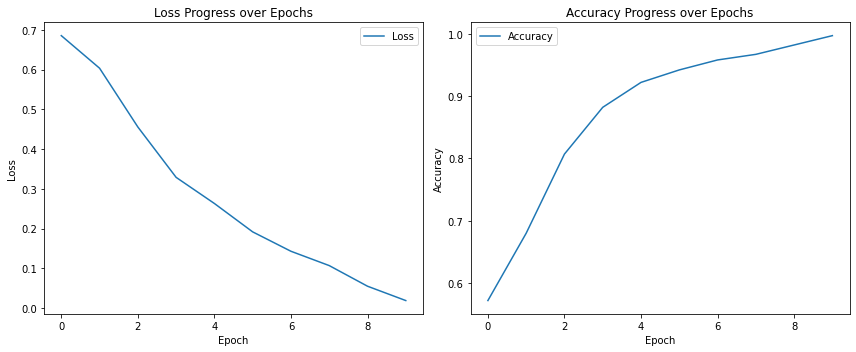

In [23]:
# Plotting the loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label='Loss')
plt.title('Loss Progress over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label='Accuracy')
plt.title('Accuracy Progress over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
